In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import scipy

## Import Dataset used for Training

In [2]:
# set the path of the images directory to a variable

data_dir = '../input/anime-faces/data/data/'

In [3]:
# use the image_dataset_from_directory function from keras utils. 
# the images are loaded in batches of size 32
# The data gets stored as tensors meaning there is no need for any datatype convertion

anime_faces = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels=None,
    label_mode=None,
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(64, 64),
    shuffle=False
)

Found 21551 files belonging to 1 classes.


2022-11-05 12:31:48.925448: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


## Load the saved Models

In [4]:
dcgan = tf.keras.models.load_model('../input/generate-anime-faces-dcgan/dcgan_generator.h5')

In [5]:
fcgan = tf.keras.models.load_model('../input/generate-anime-faces-fcgan/fcgan_generator.h5')

In [6]:
wgan = tf.keras.models.load_model('../input/generate-anime-faces-wgan/wgan_generator.h5')

In [10]:
# fixed noise to be used for all models
noise = tf.random.normal(shape = (32,64))

## Generate and Visualise

In [11]:
imgs_dcgan = dcgan.predict(noise)
imgs_dcgan = (imgs_dcgan * 127.5) + 127.5

2022-11-05 12:33:36.796906: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [12]:
imgs_fcgan = fcgan.predict(noise)
imgs_fcgan = tf.reshape(tensor = imgs_fcgan, shape = (32, 64, 64, 3))
imgs_fcgan = (imgs_fcgan * 127.5) + 127.5

In [13]:
imgs_wgan = wgan.predict(noise)
imgs_wgan = (imgs_wgan * 127.5) + 127.5

In [14]:
def visualize(imgs):
    # use subplots to display all the 32 images of one batch
    rows = 4
    cols = 8
    fig, ax = plt.subplots(nrows = rows, ncols = cols, figsize = (20,10))
    for i in range(rows):
        for j in range(cols):
            index = i * cols + j
            img_disp = tf.cast(imgs[index], tf.int32)    # cast to tf.int32 as the tf.float32 does not get us the image output as desired
            ax[i, j].imshow(img_disp)
            ax[i, j].axis('off')    # remove axis from the current subplot
    plt.show()

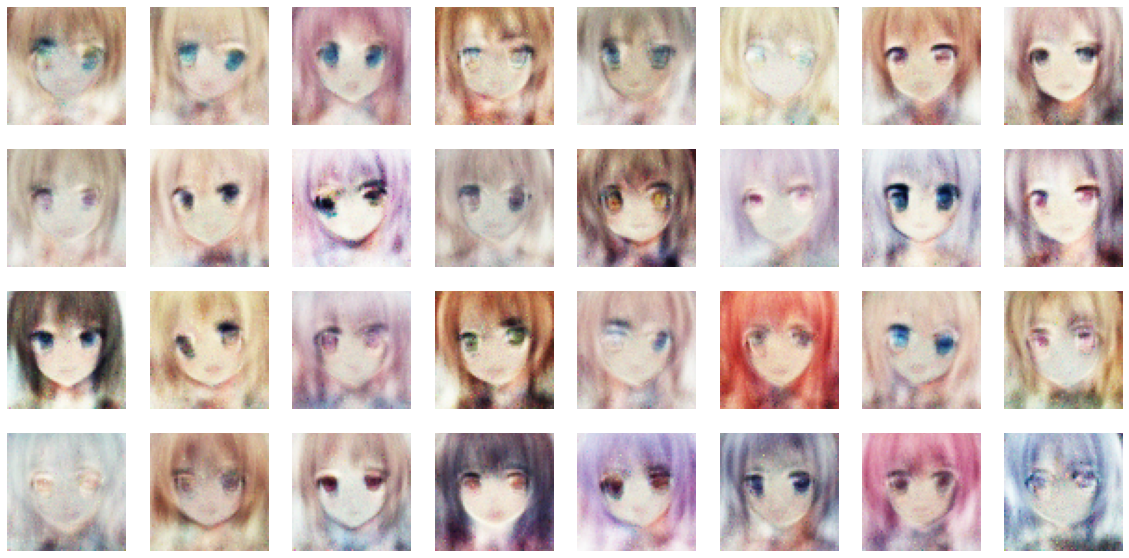

In [15]:
visualize(imgs_fcgan)

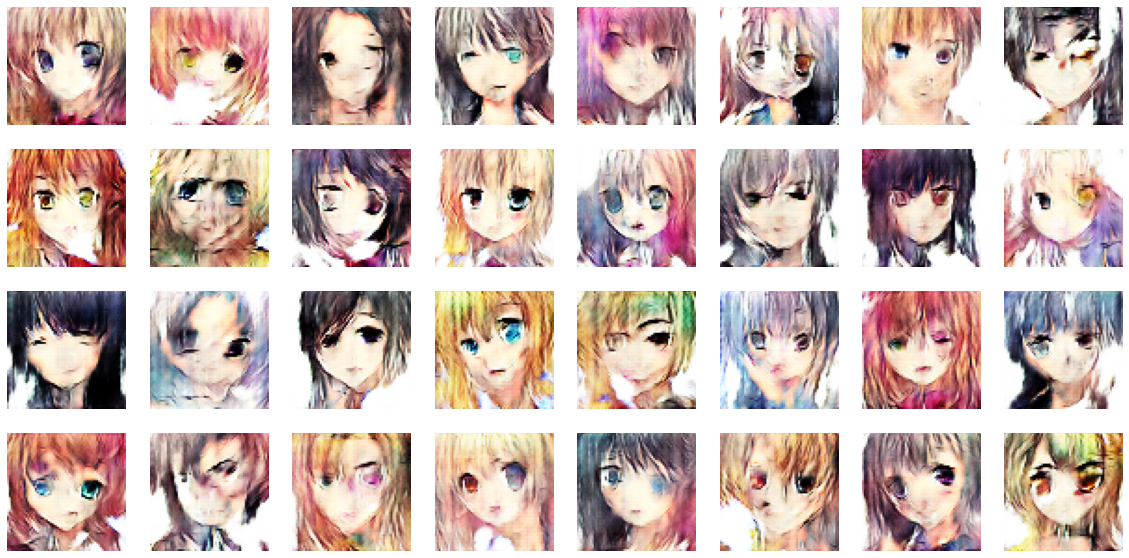

In [16]:
visualize(imgs_dcgan)

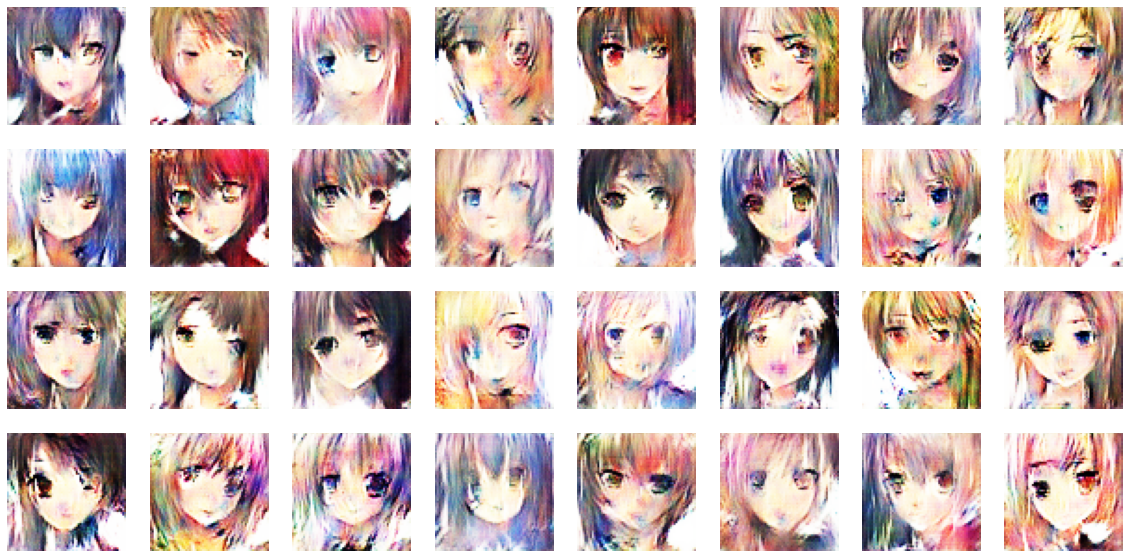

In [17]:
visualize(imgs_wgan)

## Setup FID code

In [18]:
inception_model = tf.keras.applications.InceptionV3(include_top = False, weights = 'imagenet', pooling = 'avg', input_shape = (75, 75, 3))

87924736/87910968 [==============================] - 4s 0us/step


In [22]:
def compute_real_embeddings(batches = 32):
    image_embeddings = []
    
    iterator = iter(anime_faces)
    
    for _ in range(batches):
        real_imgs = iterator.get_next()
        real_imgs = (real_imgs - 127.5) / 127.5
        real_imgs = tf.image.resize_with_pad(real_imgs, target_height = 75, target_width = 75)
        embeddings = inception_model.predict(real_imgs)
        
        image_embeddings.extend(embeddings)
        
    return tf.convert_to_tensor(image_embeddings)

In [23]:
def compute_fake_embeddings(imgs):
    
    embeddings = inception_model.predict(imgs)
    
    return embeddings

In [ ]:
real_embeddings = compute_real_embeddings()

In [25]:
dcgan_embeddings = []
fcgan_embeddings = []
wgan_embeddings = []


for _ in range(32):
    
    noise = tf.random.normal(shape = (32,64))
    
    imgs_dcgan = dcgan.predict(noise)
    imgs_dcgan = tf.image.resize_with_pad(imgs_dcgan, target_height = 75, target_width = 75)
    
    imgs_fcgan = fcgan.predict(noise)
    imgs_fcgan = tf.reshape(tensor = imgs_fcgan, shape = (32, 64, 64, 3))
    imgs_fcgan = tf.image.resize_with_pad(imgs_fcgan, target_height = 75, target_width = 75)
    
    imgs_wgan = wgan.predict(noise)
    imgs_wgan = tf.image.resize_with_pad(imgs_wgan, target_height = 75, target_width = 75)
    
    dcgan_embeddings.extend(compute_fake_embeddings(imgs_dcgan))
    fcgan_embeddings.extend(compute_fake_embeddings(imgs_fcgan))
    wgan_embeddings.extend(compute_fake_embeddings(imgs_wgan))
    
real_embeddings = np.array(real_embeddings)
dcgan_embeddings = np.array(dcgan_embeddings)
fcgan_embeddings = np.array(fcgan_embeddings)
wgan_embeddings = np.array(wgan_embeddings)

In [26]:
def calculate_fid_score(real_embeddings, fake_embeddings):
    
    mu_real = np.mean(real_embeddings, axis = 0)
    mu_fake = np.mean(fake_embeddings, axis = 0)
    
    sigma_real = np.cov(real_embeddings, rowvar = False)
    sigma_fake = np.cov(fake_embeddings, rowvar = False)
    
    squared_diff = np.sum((mu_real - mu_fake) ** 2)
    
    covmean = scipy.linalg.sqrtm(sigma_real.dot(sigma_fake))
    
    if np.iscomplexobj(covmean):
        covmean = covmean.real
        
    fid_score = squared_diff + np.trace(sigma_real + sigma_fake - 2 * covmean)
    
    return fid_score

## Calculating the FID score using the embeddings

In [30]:
calculate_fid_score(real_embeddings, fcgan_embeddings)

1645.9759053098464

In [27]:
calculate_fid_score(real_embeddings, dcgan_embeddings)

1060.6110589215714

In [29]:
calculate_fid_score(real_embeddings, wgan_embeddings)

804.8744022984994

In terms of FID score (lower the better) the models arranged based on performance:  
1. WGAN (Wasserstein GAN)  
2. DCGAN (Deep Convolutional GAN)
3. FCGAN (Fully Connected GAN)